In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Part 1
Team members:
* Marisol Velapatiño
* Ivo Kusijanovic

# Part 2


*Some parts of this project require a good understanding of the Ultrasonic welding process. Find one or more research papers that explain this process in detail. Then, write a brief description of the Ultrasonic welding process in a single short paragraph, and ensure you correctly reference your data source(s). No AI summary report. Write your own report*

**Ultrasonic welding** has become important in the advent of technologies where lightweight innovations are rising. These can be related but are not limited to the automobile, aviation, and in general transport industries. Composite joints can be made up of different materials, plastic, paper, stainless steel, aluminum to produce high-end quality lightweight parts. Ultrasonic welding is an industry preferred process thanks to its fast welding time to connect components into a solid state. The ultrasonic welding process is a projected type technique of binding : The process needs a vertical force that makes contact with the components through a horn. These components are placed in an anvil and oscillet at high frequencies in the kHz. The energy used and other parameters are dependent on the material being welded. In this project the following will be analyzed: ....

# Part 3
Part 3 Learn to use datasets (30 points):
An ultrasonic welding machine was used to perform a set of experiments. A total of sixty-nine
welding experiments were conducted across seven pressure levels (psi): 10, 20, 30, 40, 50, 60,
and 75. Each condition was repeated ten times. During the welding experiments, two types of
signals—power and force—were collected for each sample. Subsequently, a peel test was
performed to evaluate the welding quality. Based on the results, the samples were categorized
into three classes (as shown in Figure 1): cold, excessive, and good. Dataset: Part3.zip

## Part 3.a

Data preprocessing (5 points): As shown in Figures 2 and 3, the power signals consist of a
main-weld segment and a post-weld segment, while the force signals include a pre-weld
segment, main-weld segment, and post-weld segment.

Based on a physical understanding of the welding process, we know that the main-weld segment is the most informative for quality monitoring. Therefore, our analysis will focus solely on this segment.
Develop an algorithm to automatically extract the main-weld segment for all welds. In your
report, briefly describe the algorithm and demonstrate its effectiveness using one example
for each type of signal. Specifically, plot the raw signal and highlight the boundaries of the
main-weld segment

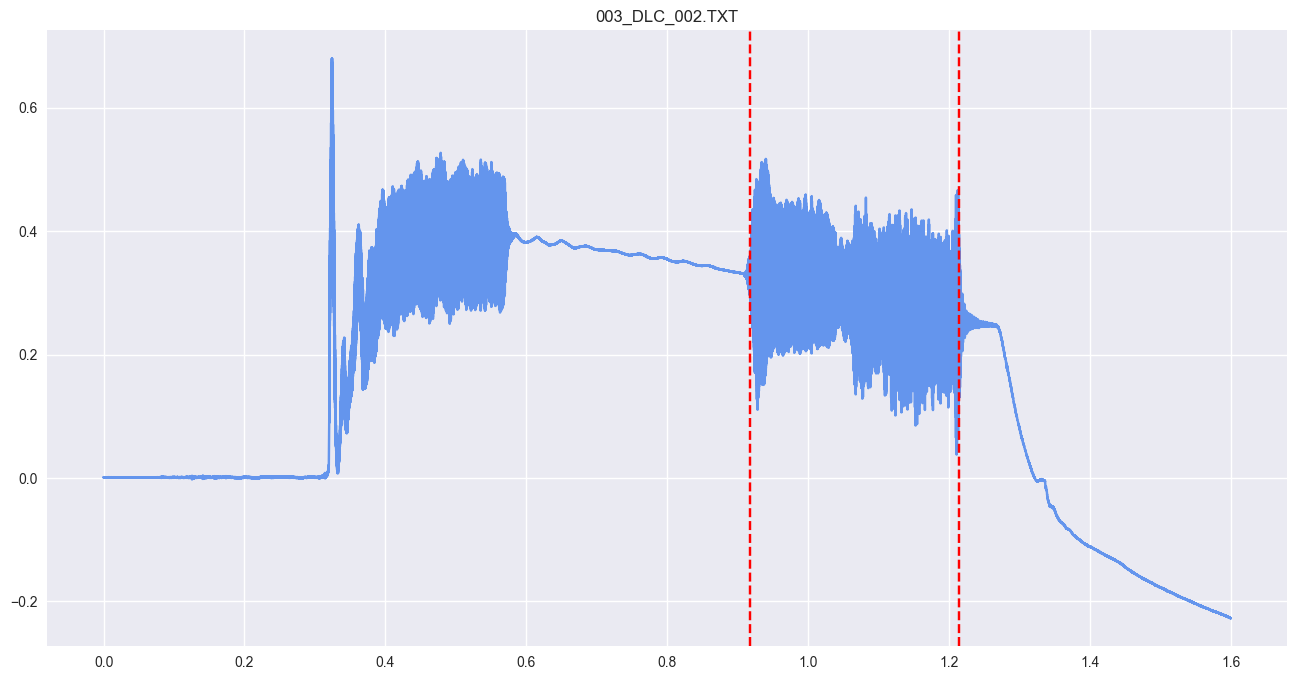

In [2]:
from part3a import extract_force_signals, extract_force_main_weld_segment

force_signals = extract_force_signals()
experiment, time, force = extract_force_main_weld_segment(*force_signals[0], plot=True)

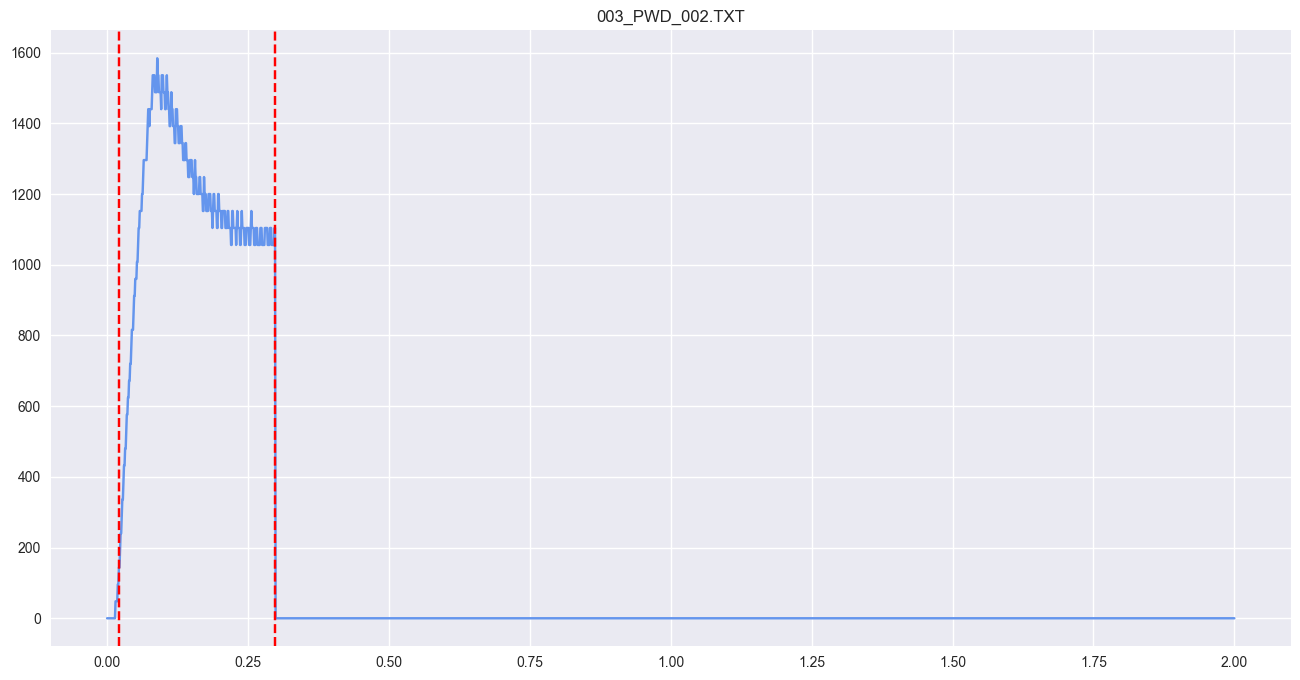

In [3]:
from part3a import extract_power_signals, extract_power_main_weld_segment

power_signals = extract_power_signals()
experiment, time, power = extract_power_main_weld_segment(*power_signals[0], plot=True)

## Part 3.b


Feature generation (8 points): Create features following the steps below and record all
features in a .csv file (part3b.csv).

Each row corresponds to one experiment and each column
corresponds to one parameter/feature. 

The columns should follow this order: experiment
number, quality label, four features from group a, four features from group b, and four
features from group c. This table should be included in your report.


* Process output signals **-Group A-** (2 points): Welding pressure, pre-height, height, and
height change. The first three were recorded by the welder. Height change is the
difference between pre-height and the height.

* Time-domain features from power signals **-Group B-** (3 points): Brainstorm and
  generate four features. In the report, provide the definitions of all features and a
  justification of why these features may be helpful.
  
  We'll be choosing highly discriminative feature that allows us to classify good welds from bad welds:

    * **risePeak** : Shows the maximum power reached during the rise and indicates whether target welding power is achieved. If in the expected range, the risePeak indicates that thermal energy coupled efficiently into the metal which likely produces a good weld. Else if it's too low, the risePeak indicates insufficient heat delivery, poor current conduction ( due to large surface impurity ) and thus a cold weld. If it's too high, the risePeak corresponds to an unstable heat delivery which highly leads to excessive penetration and an excessive weld. 

    * **riseSlope**: This measures how quickly the system reaches operating power. Usually unstable welds have slower rise slopes. A fast rise indicates proper energy coupling: basically how efficiently the electrical power is delivered by the welding machine into heat energy transferred to the joint. A slow or noisy rise means the connection struggles to form and the power is lost to poor contact or instability.

    * **riseDuration**: Indicates the time needed to reach the peak and is complementary to the riseSlope. As explained earlier, a longer rise duration generally correlate with poor contact and energy coupling which can cause a bad weld.

    * **dipDepth**: This is the change in height between the risePeak and the ramp/stable power signal. A deep dip after the risePeak likely means that the controller had to pull back to correct and overshoot, indicating a poor heat transfer and bad weld. Conforming welds usually have shallow dip, indicating efficient heat transfer.

* Frequency-domain features from force signals **-Group C-** (3 points): Generate the
following features: 1st peak frequency and magnitude, 2nd peak frequency and
magnitude.

In [4]:
from part3b import extract_features_group_b, extract_features_group_c

name = "part3b.csv"
col_names = ["experiment number", "quality label", "Welding Pressure", "pre-height", "height", "height change", "risePeak", "riseSlope", "riseDuration", "dipDepth", "1peakFreq" , "1peakMag", "2peakFreq", "2peakMag"]
file  = './data/part3/WeldClassification.xls'

df_raw = pd.read_excel(file, skiprows=6)

zero_data = np.zeros(shape=(len(df_raw['Run No.']),len(col_names)))

df = pd.DataFrame(zero_data, columns=col_names)

## Group A

df[col_names[0]] = df_raw['Run No.']
df[col_names[1]] = df_raw['Class Label']
df[col_names[2]] = df_raw['Pressure [psi]']
df[col_names[3]] = df_raw['PreHeight [mm]']
df[col_names[4]] = df_raw['Height [mm]']
df[col_names[5]] = abs(df_raw['Height [mm]'] - df_raw['PreHeight [mm]'])

## Group B

rise_peaks = []
rise_slopes = []
rise_durations = []
dip_depths = []

for power_signal in power_signals:
    
    experiment, time, power = extract_power_main_weld_segment(*power_signal)
    rise_peak, rise_slope, rise_duration, dip_depth = extract_features_group_b(time, power)

    rise_peaks.append(rise_peak)
    rise_slopes.append(rise_slope)
    rise_durations.append(rise_duration)
    dip_depths.append(dip_depth)

df[col_names[6]] = np.array(rise_peaks)
df[col_names[7]] = np.array(rise_slopes)
df[col_names[8]] = np.array(rise_durations)
df[col_names[9]] = np.array(dip_depths)

## Group C

first_peak_freqs = []
first_peak_magns = []
second_peak_freqs = []
second_peak_magns = []

for force_signal in force_signals:
    
    experiment, time, force = extract_force_main_weld_segment(*force_signal)
    first_peak_freq, first_peak_magn, second_peak_freq, second_peak_magn = extract_features_group_c(time, force)

    first_peak_freqs.append(first_peak_freq)
    first_peak_magns.append(first_peak_magn)
    second_peak_freqs.append(second_peak_freq)
    second_peak_magns.append(second_peak_magn)

df[col_names[10]] = np.array(first_peak_freqs)
df[col_names[11]] = np.array(first_peak_magns)
df[col_names[12]] = np.array(second_peak_freqs)
df[col_names[13]] = np.array(second_peak_magns)

# Part 3.c

In [5]:
print(df.head())

   experiment number quality label  Welding Pressure  pre-height  height  \
0                  2             I                10        0.81    0.67   
1                  3             I                10        0.83    0.67   
2                  4             I                10        0.78    0.63   
3                  5             I                10        0.81    0.67   
4                  6             I                10        0.83    0.67   

   height change  risePeak     riseSlope  riseDuration  dipDepth  \
0           0.14    1536.0  16571.406571         0.062     480.0   
1           0.16    1584.0  18461.516462         0.056     432.0   
2           0.15    1584.0  18835.423038         0.059     432.0   
3           0.14    1488.0  17684.188526         0.054     336.0   
4           0.16    1632.0  17560.953610         0.060     480.0   

      1peakFreq  1peakMag     2peakFreq  2peakMag  
0  19982.462649  0.354729      3.372568  0.153667  
1  19989.189554  0.460099  199

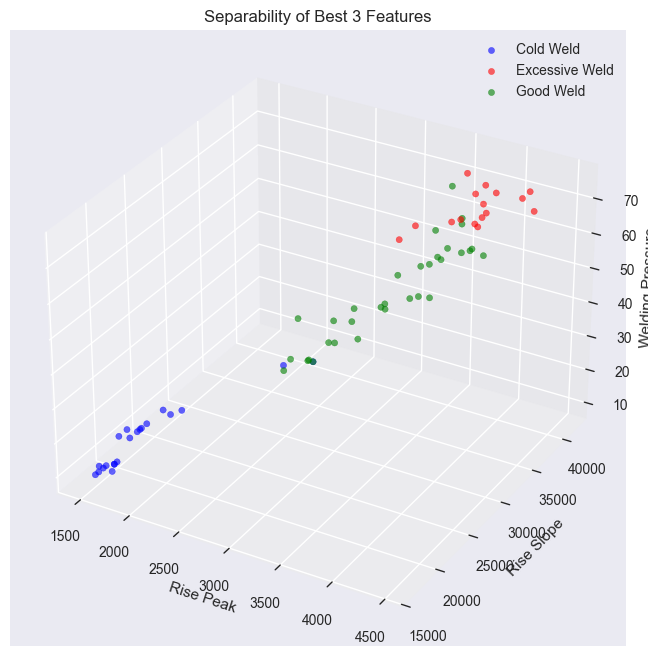

In [6]:
from part3c import plot_best_features

best_features = plot_best_features(df)

# Part 3.d

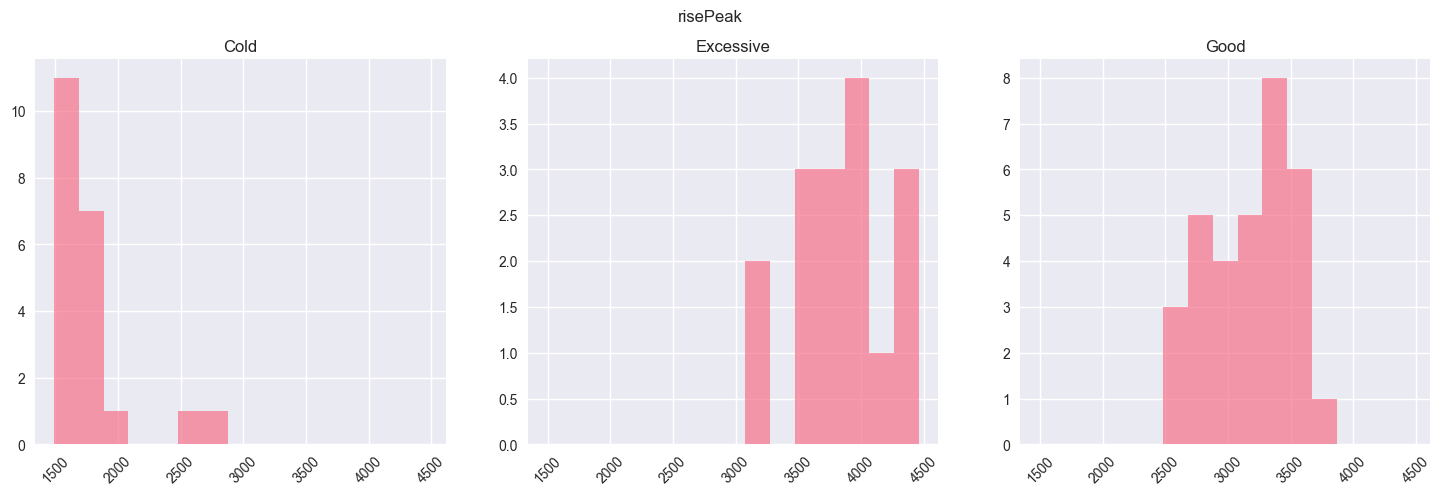

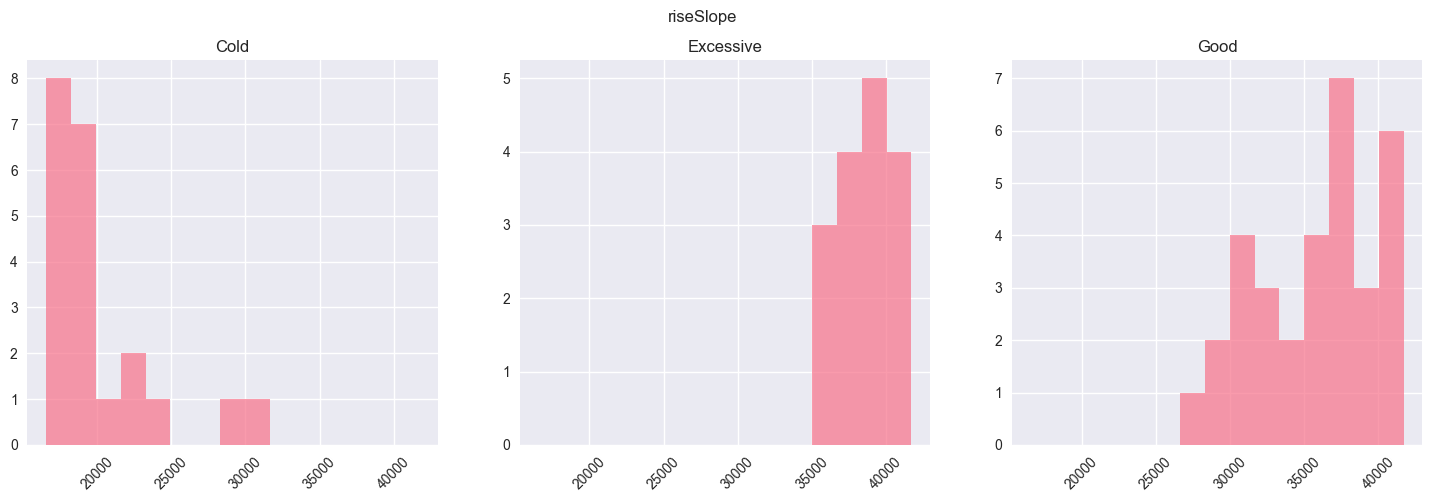

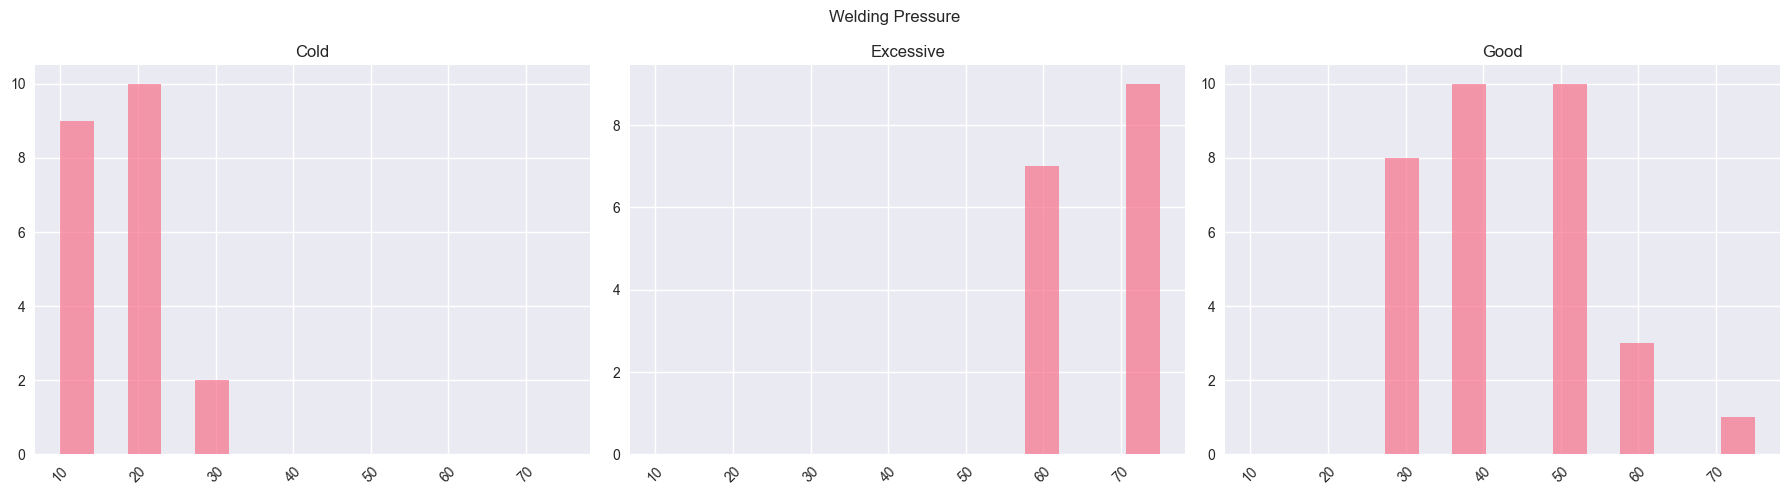

In [7]:
from part3d import plot_class_feature_histograms, plot_shewart_control_chart, get_misclassification_rates

plot_class_feature_histograms(df, best_features)

The classifier revolves around using a Shewhart Control Chart on good-labeled welds. Then, any data point falling outside the lower and upper control limits would be classified as bad (i.e. cold or excessive).

Now the hyper-parameter that we can tune is **k**, the number of standard deviations away from the center line. Although we typically use k=3 as it would enclose around 99.73% of the data, this would likley cause us to underfit our data, causing us to likley classify bad welds as good. Conversely, we can't set k to just fit our train data (i.e. small k) as this would lead to overfitting, causing us to likley classify good welds as bad. Thus, we have to find a balance. 

Exploring different ks we saw that setting k=2 provides a sufficiently good classification boundary as to neither overfit or underfit. To provide some more insight, we changed k until there was a decently big margin between the largest good-labeled value and the UCL, and the smallest good-labeled value and the LCL. Moreover, this wasn't the only condition as we ignored outlier good-labeled values as seen for the Welding Pressure Shewhart Control Chart classifier. 

Just as an aside we more commonly label excessive welds as good in comparison to cold welds, especially for the riseSlope feature where we misclassified all execssive welds as good. Nevertheless, as seen in part (c) the combination of these features in three dimensional space does provide clear separability between the independent classes of cold, good, and excessive, not just good and bad. Thus, it's best to use them in unison. 

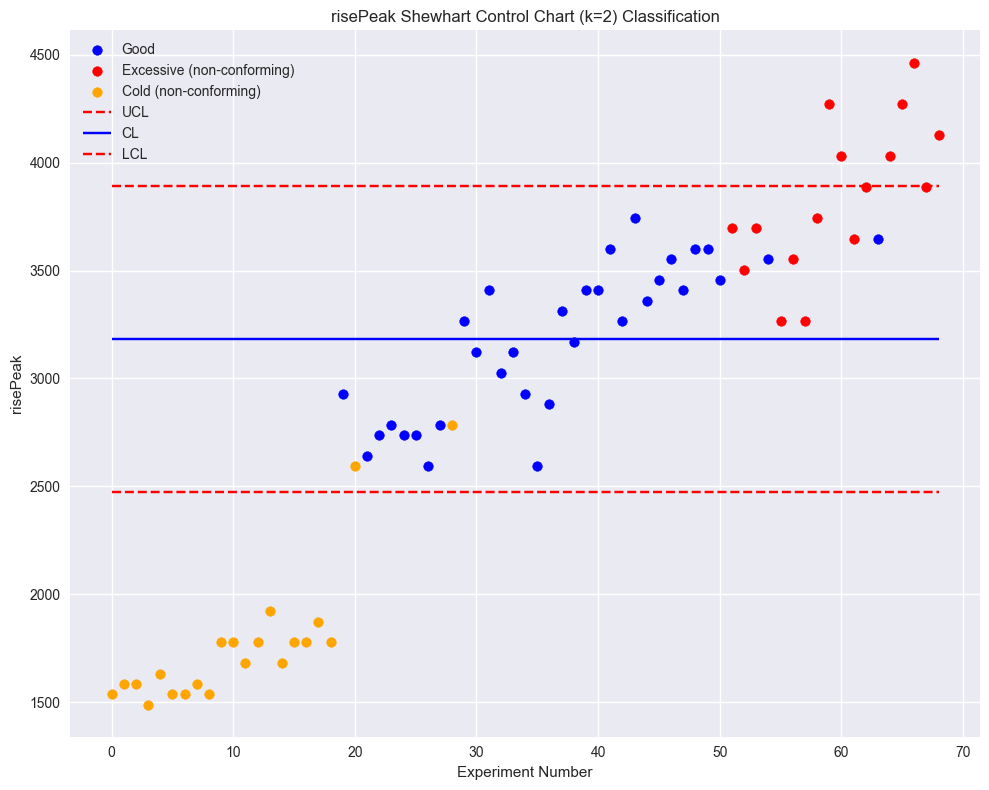

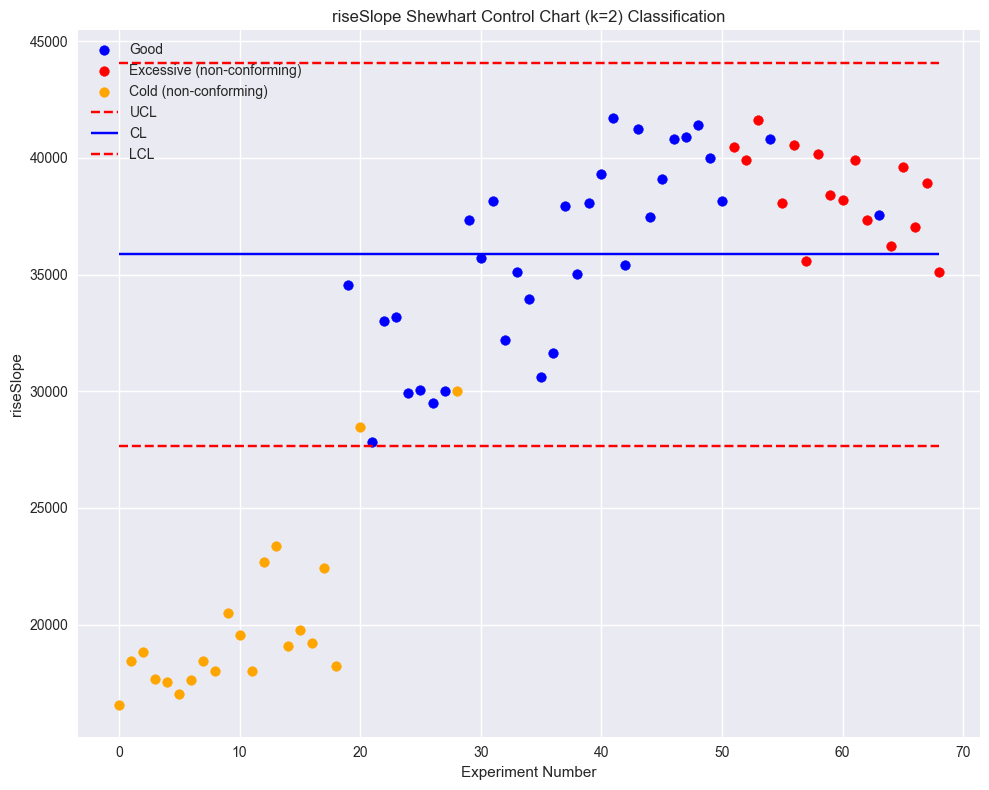

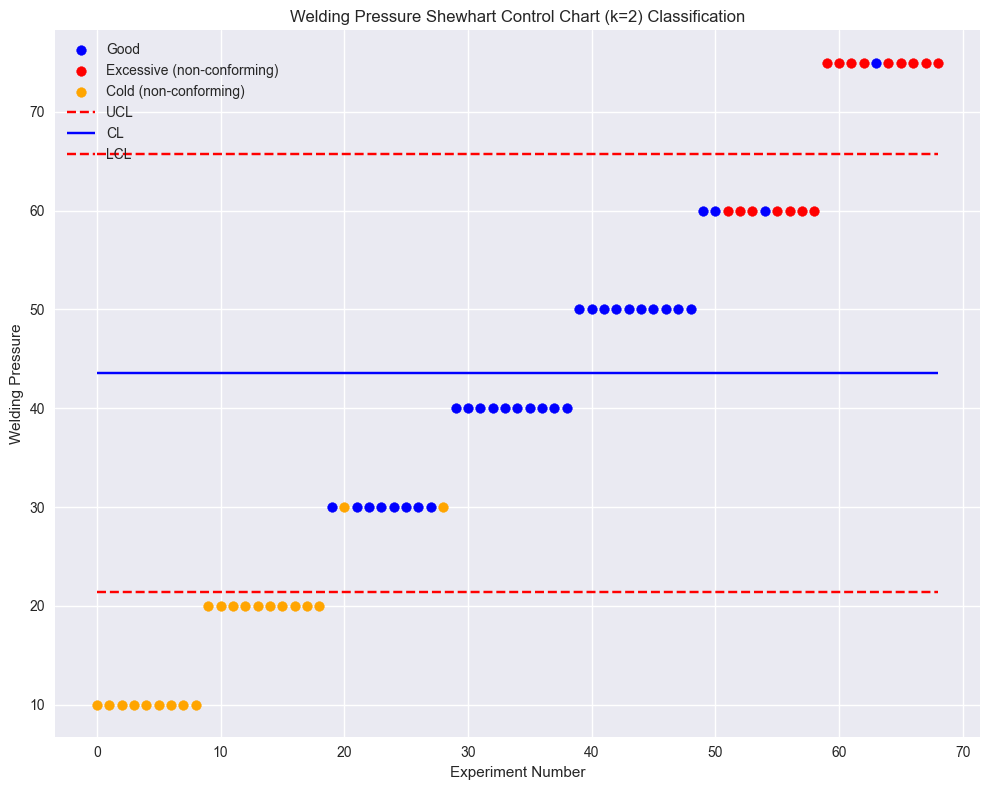

In [8]:
control_limits = plot_shewart_control_chart(df, best_features, k=2)

In [9]:
misclassification_rates = get_misclassification_rates(df, best_features, control_limits)

for feature, misclassification_rate in zip(best_features, misclassification_rates):
    print(f"{feature} misclassification rate: {misclassification_rate * 100:.2f}%")

risePeak misclassification rate: 17.39%
riseSlope misclassification rate: 26.09%
Welding Pressure misclassification rate: 14.49%


# Part 3.e

Based on the analysis above the **power sensor** is more useful for quality monitoring. Firstly, based on the fischer ratio, two of the features extracted from the power signals (risePeak, and riseSlope) provide high inter-class variance. We can clearly see this class seprability, not just from conforming vs non-conforming parts. Secondly, using a simple control limit (k=2) classifier we are able to get a fairly low misclassification rate (17.39%, and 26.09%) which is far better than guessing if the part was conforming or not. 

Furthermore, we can extend our analysis by calculating the misclassification rate of the features extracted from the force signal. We find that 3 out of 4 of these misclassification rates hover above 50%, which is worse than just guessing. 

# Part 4 


For this part, use the dataset provided from an Ultrasonic welding process. For your convenience,
we have extracted 12 features, which are available in the attached part4.csv file. To avoid any bias
from the results of the previous part and to facilitate a data-driven analysis, all features have been
normalized and anonymized. This processing will not affect the classification performance.

In [10]:
data4 = "./data/part4.csv"

## Part 4.a

Feature selection (10 points): Select a subset of features to use in your classifiers. Describe
the procedure or method you use and explain your reasoning. Note: you may select different
subsets of features for each classifier : 


### Fisher's ratio approach :


We'll use the fisher's ratio to rank fatures based on how well they discriminate Good-Cold, Good-Excessive welds. Similar to the part 3 approach, we'll select the adequate number features from the feature pool based on the following criterion: max (Fisher’s ratio 1 + Fisher’s ratio 2). 


In [11]:
from part4a import get_best_features

df_data4 = pd.read_csv(data4)
best_features = get_best_features(df_data4)

Cumulative sum of ratios: [np.float64(0.15544411626272514), np.float64(0.3028376106256886), np.float64(0.4489712240961773), np.float64(0.5940488473888776), np.float64(0.7314874468175232)]
Best 5 features are: Index(['Feature 5', 'Feature 8', 'Feature 9', 'Feature 1', 'Feature 7'], dtype='object')


We set an 80% threshold for the cumulative sum of the fisher ratios. This way we capture most of the discriminatory power using a minimum number of features. We get 5 features: 5, 8, 9, 1, 7 in decreasing order of ratio.

## Part 4.b

Classification (15 points): Choose three different classifiers (either covered in class or
otherwise). Train and test the performance of each model. Use a suitable method or
technique to split the dataset into training and testing subsets. Explain your choice of method
or technique.

We used K-Fold Cross-Validation to split the dataset as it provides a more reliable estimate of the model performance. This is because we don't rely on a single train-test split to measure the model's performance, rather we average the performance across K distinct train-test splits. This way we reduce randomness and don't worry about the model overperfroming or underperforming from its true ability due to a lucky or unlucky split. Furthermore, using K-Fold Cross Validation we guarantee that almost all (since we use shuffle=True) data points are used in the test set. This way we are more sure that the model's performance doesn't rely on a few data point being present in the train set. This is unlike calling train_test_split K times which doesn't gurantee any of this behavior. 

In [24]:
from part4b import classify

X = df_data4[best_features].iloc[:, :]
y = df_data4.iloc[:,1]

### LDA

In [13]:
lda = LDA()
_, confusion_matrices_lda = classify(X, y, lda, "Linear Discriminant Analysis")

Fold 1
Linear Discriminant Analysis Accuracy: 0.9285714285714286
######################################################################
Fold 2
Linear Discriminant Analysis Accuracy: 0.8571428571428571
######################################################################
Fold 3
Linear Discriminant Analysis Accuracy: 1.0
######################################################################
Fold 4
Linear Discriminant Analysis Accuracy: 0.9285714285714286
######################################################################
Fold 5
Linear Discriminant Analysis Accuracy: 0.7692307692307693
######################################################################
Average Linear Discriminant Analysis Accuracy: 0.8967032967032967


### QDA

In [14]:
qda = QDA()
_, confusion_matrices_qda = classify(X, y, qda, "Quadratic Discriminant Analysis")

Fold 1
Quadratic Discriminant Analysis Accuracy: 0.9285714285714286
######################################################################
Fold 2
Quadratic Discriminant Analysis Accuracy: 0.7142857142857143
######################################################################
Fold 3
Quadratic Discriminant Analysis Accuracy: 0.7857142857142857
######################################################################
Fold 4
Quadratic Discriminant Analysis Accuracy: 0.8571428571428571
######################################################################
Fold 5
Quadratic Discriminant Analysis Accuracy: 0.9230769230769231
######################################################################
Average Quadratic Discriminant Analysis Accuracy: 0.8417582417582418


/Users/ivokusijanovic/Desktop/UIUC/Fa25/ME 453/Final Project/venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/ivokusijanovic/Desktop/UIUC/Fa25/ME 453/Final Project/venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/ivokusijanovic/Desktop/UIUC/Fa25/ME 453/Final Project/venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/ivokusijanovic/Desktop/UIUC/Fa25/ME 453/Final Project/venv/lib/python3.13/site-packages/sk

### SVM with different kernels

In [15]:
kernels = ["linear", "rbf", "poly"]

confusion_matrices_svms = []

for kernel in kernels:
    
    svm = SVC(kernel=kernel)
    _, confusion_matrices_fold = classify(X, y, svm, f"{kernel[0].upper() + kernel[1:].lower()} Kernel SVM")
    confusion_matrices_svms.append(confusion_matrices_fold)
    print()


Fold 1
Linear Kernel SVM Accuracy: 0.9285714285714286
######################################################################
Fold 2
Linear Kernel SVM Accuracy: 0.7857142857142857
######################################################################
Fold 3
Linear Kernel SVM Accuracy: 0.9285714285714286
######################################################################
Fold 4
Linear Kernel SVM Accuracy: 0.8571428571428571
######################################################################
Fold 5
Linear Kernel SVM Accuracy: 0.7692307692307693
######################################################################
Average Linear Kernel SVM Accuracy: 0.853846153846154

Fold 1
Rbf Kernel SVM Accuracy: 0.9285714285714286
######################################################################
Fold 2
Rbf Kernel SVM Accuracy: 0.7857142857142857
######################################################################
Fold 3
Rbf Kernel SVM Accuracy: 0.7857142857142857
#########################

In [16]:
ks = [2, 4, 5, 8, 10, 15]

confusion_matrices_knn = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    _, confusion_matrices_fold = classify(X, y, knn, f"KNN (k={k})")
    confusion_matrices_knn.append(confusion_matrices_fold)
    print()

Fold 1
KNN (k=2) Accuracy: 1.0
######################################################################
Fold 2
KNN (k=2) Accuracy: 0.8571428571428571
######################################################################
Fold 3
KNN (k=2) Accuracy: 0.7857142857142857
######################################################################
Fold 4
KNN (k=2) Accuracy: 0.8571428571428571
######################################################################
Fold 5
KNN (k=2) Accuracy: 0.7692307692307693
######################################################################
Average KNN (k=2) Accuracy: 0.8538461538461538

Fold 1
KNN (k=4) Accuracy: 1.0
######################################################################
Fold 2
KNN (k=4) Accuracy: 0.8571428571428571
######################################################################
Fold 3
KNN (k=4) Accuracy: 0.8571428571428571
######################################################################
Fold 4
KNN (k=4) Accuracy: 0.9285714285714286


In [17]:
max_depths = [2, 4, 5, 8, 10, 15]

confusion_matrices_random_forest = []
for max_depth in max_depths:
    knn = RandomForestClassifier(max_depth=max_depth, random_state=42)
    _, confusion_matrices_fold = classify(X, y, knn, f"Random Forest (max_depth={max_depth})")
    confusion_matrices_random_forest.append(confusion_matrices_fold)
    print()

Fold 1
Random Forest (max_depth=2) Accuracy: 1.0
######################################################################
Fold 2
Random Forest (max_depth=2) Accuracy: 0.7857142857142857
######################################################################
Fold 3
Random Forest (max_depth=2) Accuracy: 0.7857142857142857
######################################################################
Fold 4
Random Forest (max_depth=2) Accuracy: 0.9285714285714286
######################################################################
Fold 5
Random Forest (max_depth=2) Accuracy: 0.7692307692307693
######################################################################
Average Random Forest (max_depth=2) Accuracy: 0.8538461538461538

Fold 1
Random Forest (max_depth=4) Accuracy: 1.0
######################################################################
Fold 2
Random Forest (max_depth=4) Accuracy: 0.7857142857142857
######################################################################
Fold 3
Random Fores

## Part 4.c

Performance (10 points): Evaluate the performance of each classifier using confusion matrices
and error plots. Based on your analysis, recommend the best combination of feature subset
and classifier for this dataset, and justify your recommendation.

In [18]:
from part4c import error_plots

### LDA


Confusion matrices for LDA classifier
Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 0 7]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [0 0 8]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


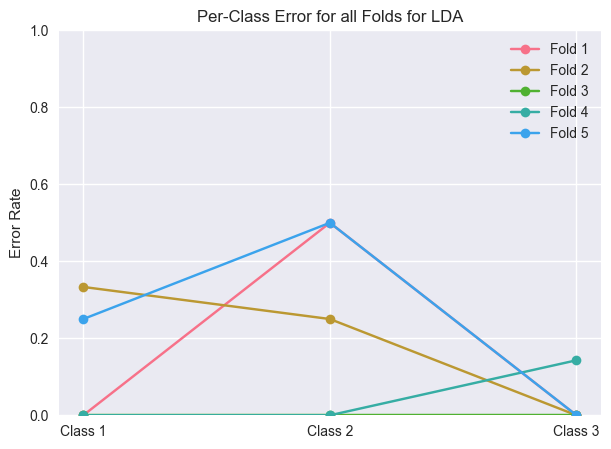

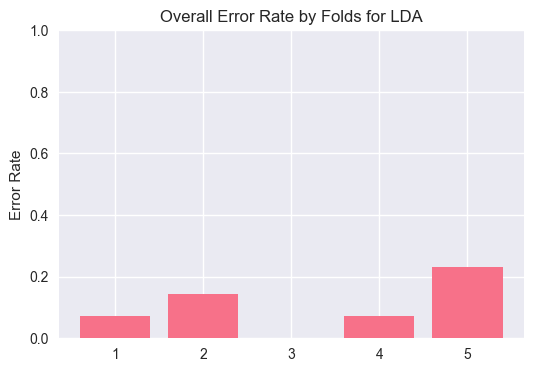

In [19]:
print("Confusion matrices for LDA classifier")
error_plots(confusion_matrices_lda, "LDA")

### QDA

Confusion matrices for QDA classifier
Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 0 7]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [0 0 8]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


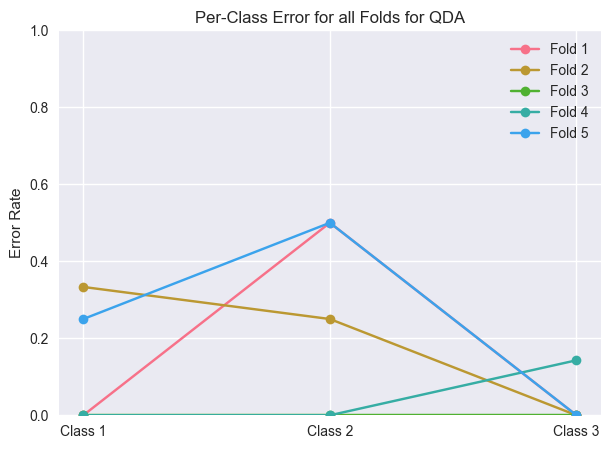

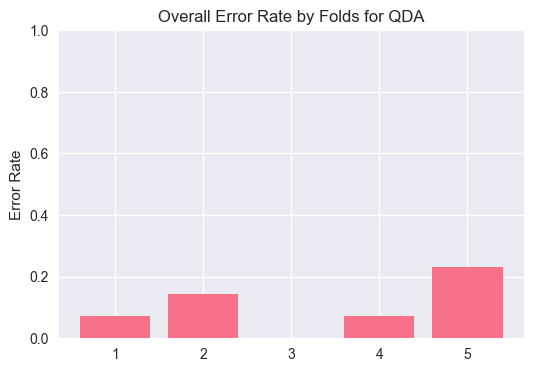

In [20]:
print("Confusion matrices for QDA classifier")
error_plots(confusion_matrices_lda, "QDA")

### SVM

Confusion matrices for SVM classifiers
Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 2 2]
 [0 0 7]]
####################
Fold 3
[[5 0 0]
 [0 0 1]
 [0 0 8]]
####################
Fold 4
[[2 0 0]
 [0 4 1]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


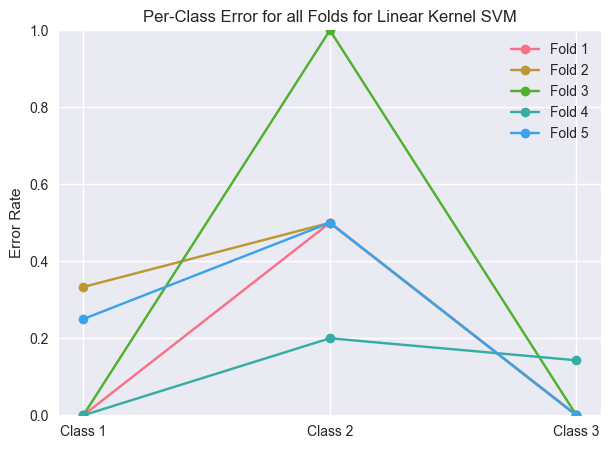

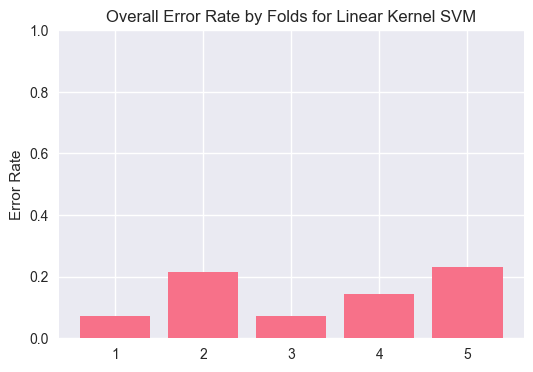

Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 2 2]
 [0 0 7]]
####################
Fold 3
[[5 0 0]
 [0 0 1]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 4 1]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


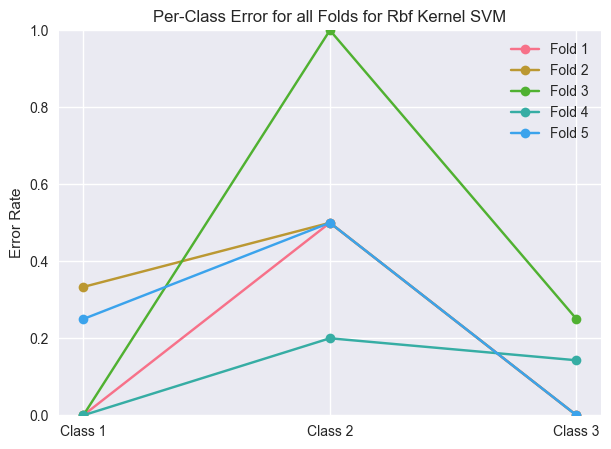

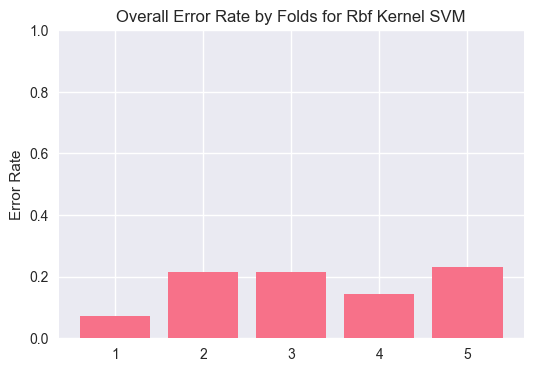

Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 4 0]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


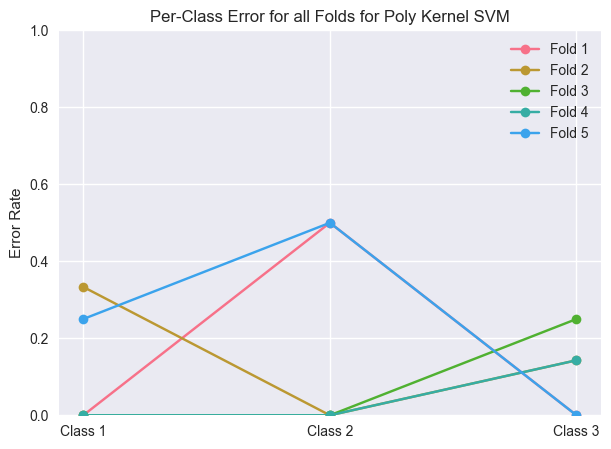

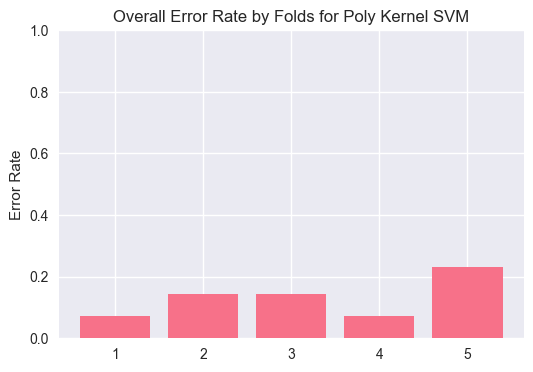

In [21]:
print("Confusion matrices for SVM classifiers")

for kernel, cm in zip(kernels, confusion_matrices_svms):
    error_plots(cm, f"{kernel[0].upper() + kernel[1:].lower()} Kernel SVM")

Confusion matrices for KNN classifiers
Fold 1
[[7 0 0]
 [0 2 0]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 4 0]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [1 2 5]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [1 1 5]]
####################
Fold 5
[[3 0 1]
 [0 3 1]
 [1 0 4]]
####################


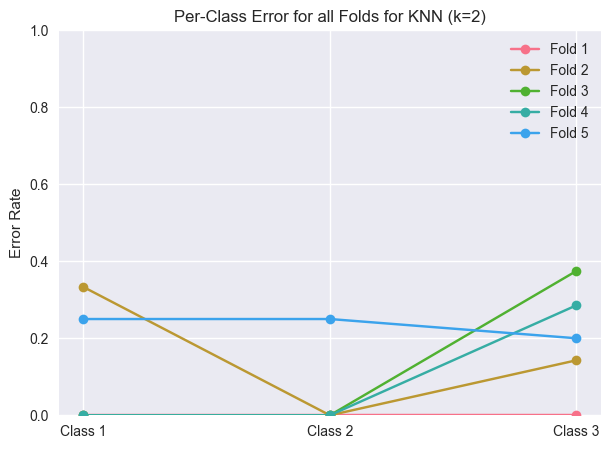

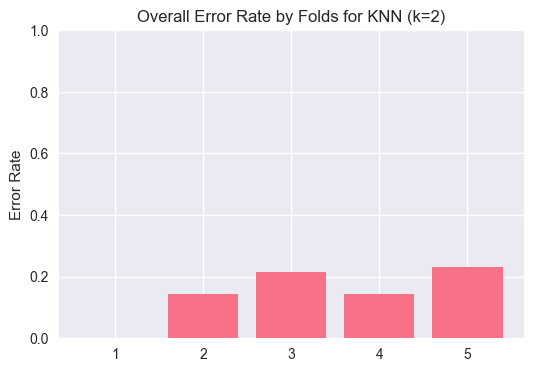

Fold 1
[[7 0 0]
 [0 2 0]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 4 0]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 4 0]
 [0 0 5]]
####################


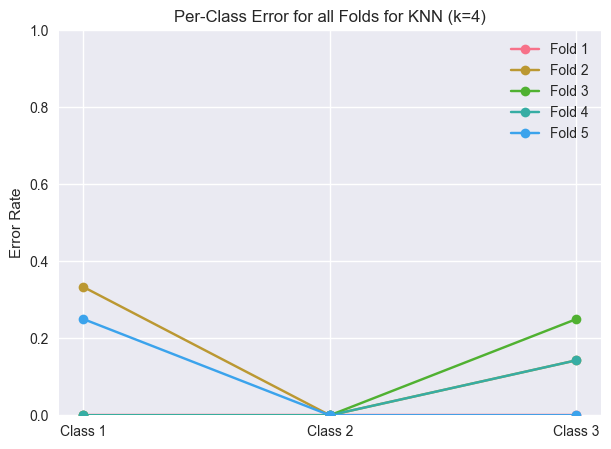

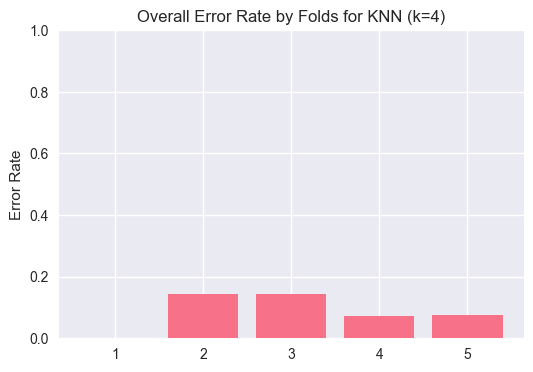

Fold 1
[[7 0 0]
 [0 2 0]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 0 1]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 3 1]
 [0 0 5]]
####################


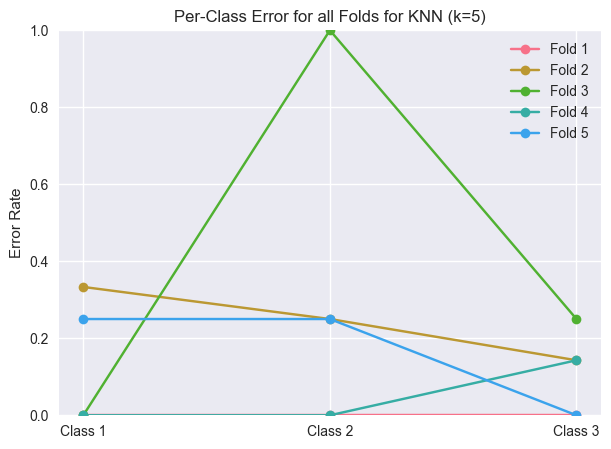

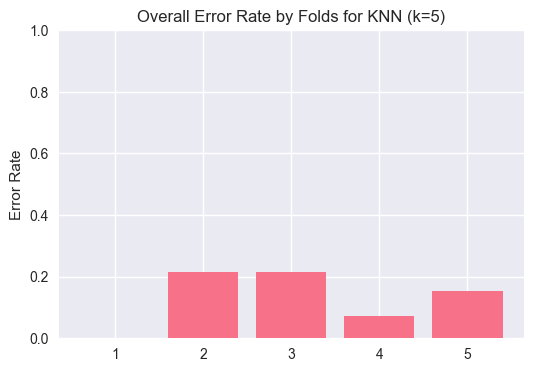

Fold 1
[[7 0 0]
 [0 2 0]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 0 1]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 3 1]
 [0 0 5]]
####################


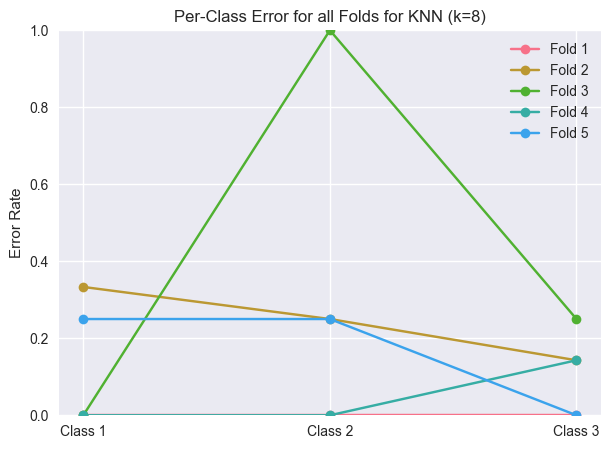

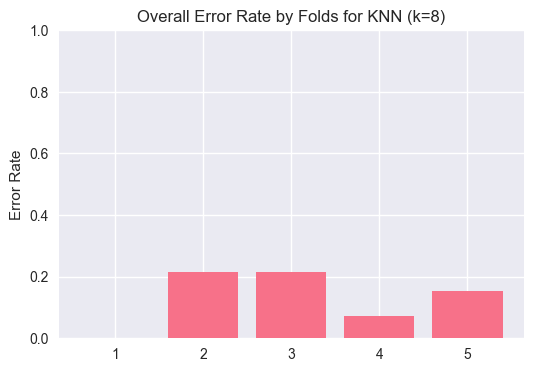

Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 0 1]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


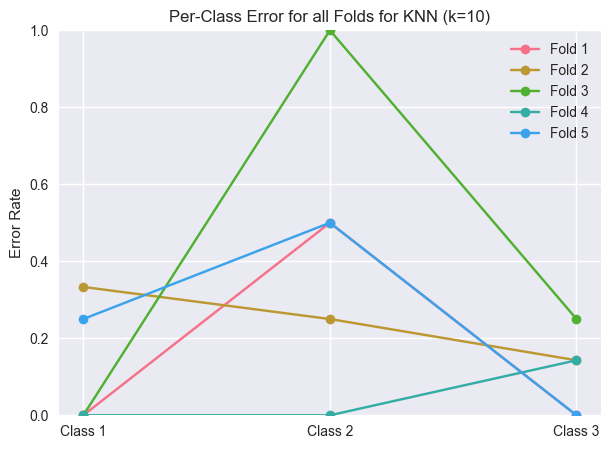

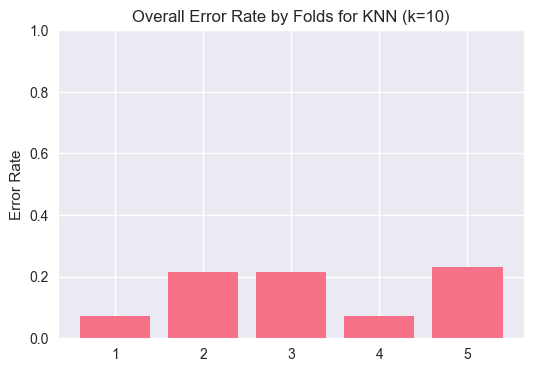

Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 2 2]
 [0 0 7]]
####################
Fold 3
[[5 0 0]
 [0 0 1]
 [0 0 8]]
####################
Fold 4
[[2 0 0]
 [0 4 1]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


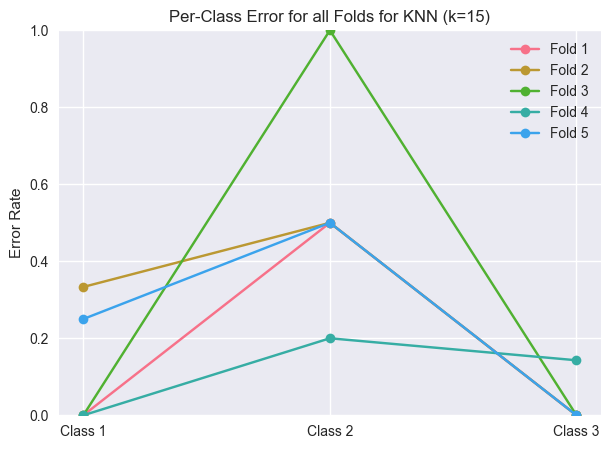

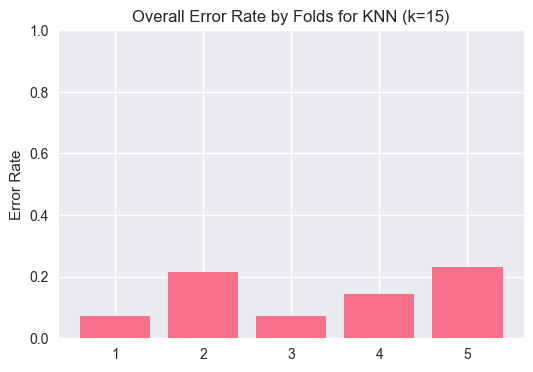

In [22]:
print("Confusion matrices for KNN classifiers")

for k, cm in zip(ks, confusion_matrices_knn):
    error_plots(cm, f"KNN (k={k})")

Confusion matrices for Random Forest classifiers
Fold 1
[[7 0 0]
 [0 2 0]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 0 1]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


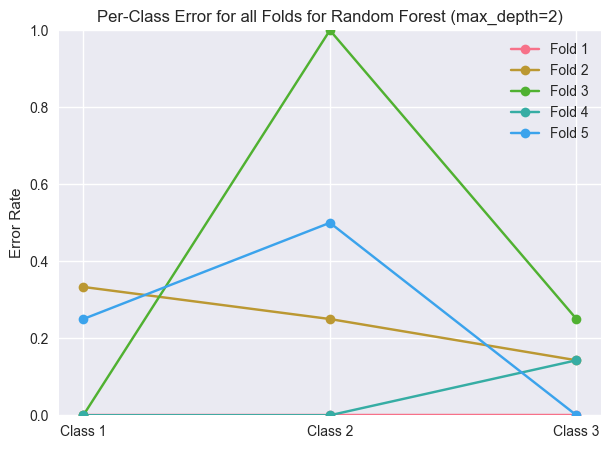

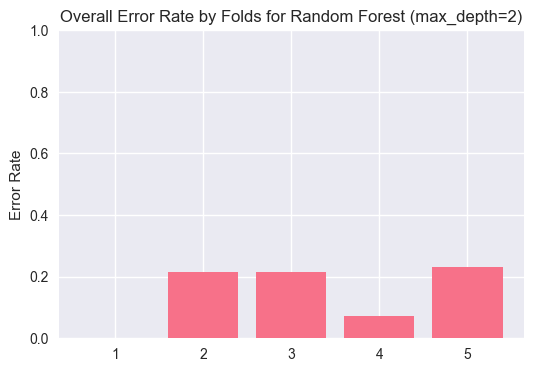

Fold 1
[[7 0 0]
 [0 2 0]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 0 1]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [0 1 6]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


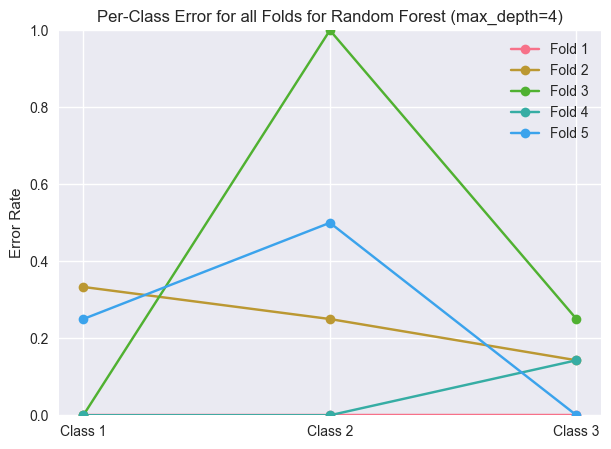

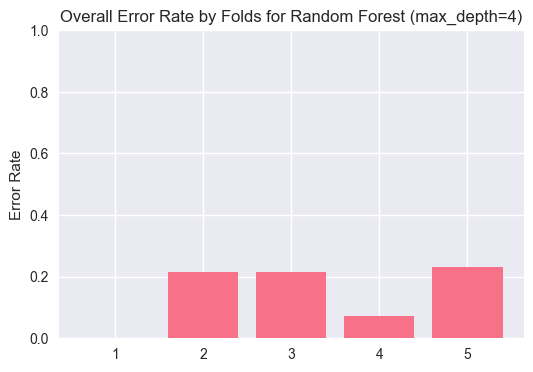

Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 2 2]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [1 1 5]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


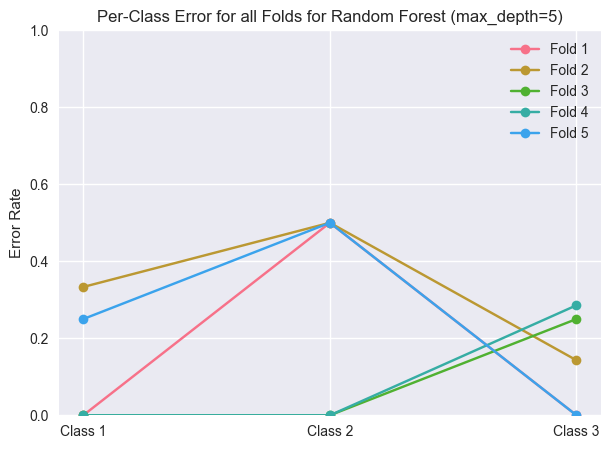

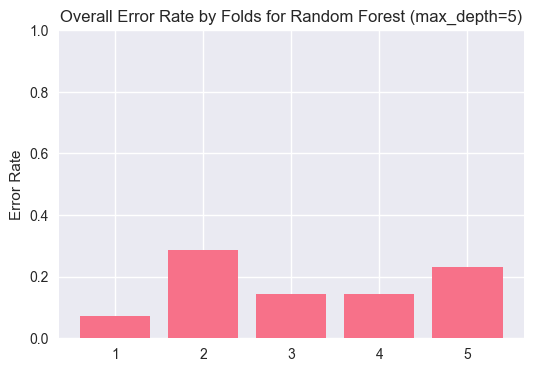

Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [1 1 5]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


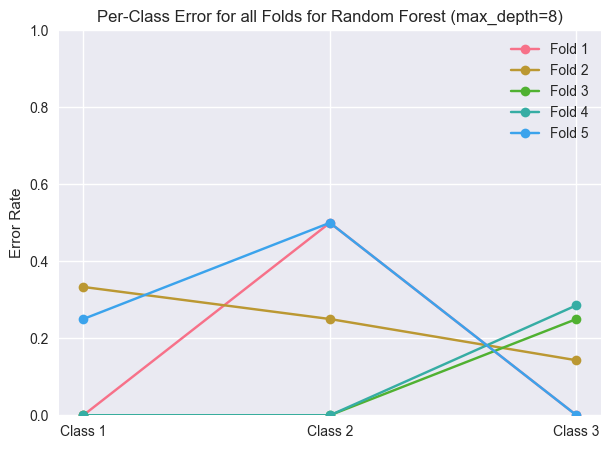

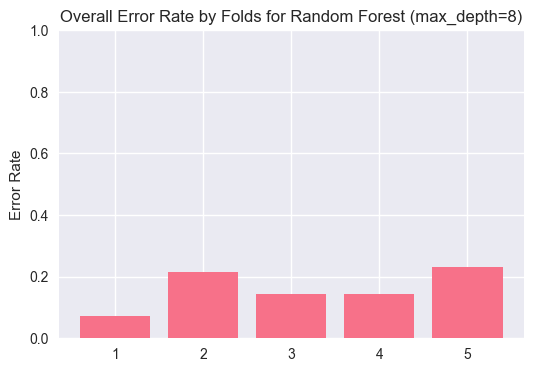

Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [1 1 5]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


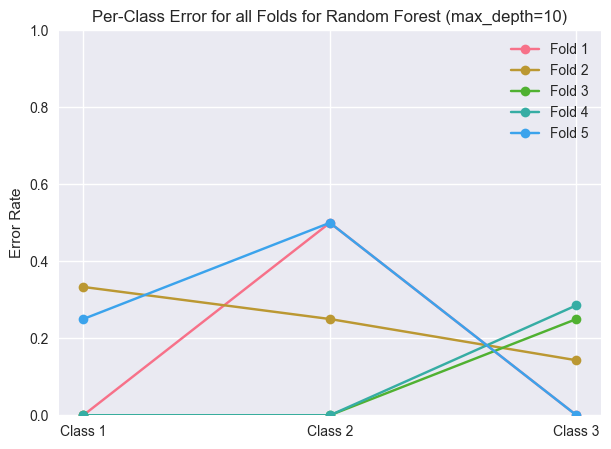

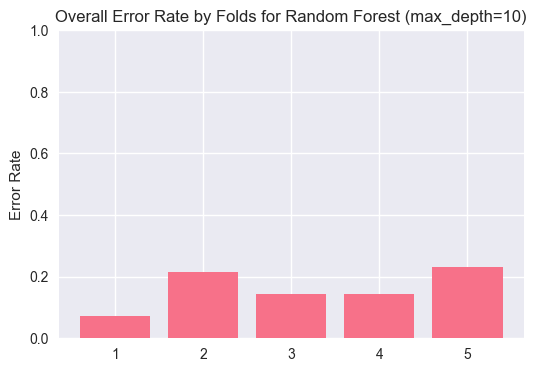

Fold 1
[[7 0 0]
 [0 1 1]
 [0 0 5]]
####################
Fold 2
[[2 0 1]
 [0 3 1]
 [0 1 6]]
####################
Fold 3
[[5 0 0]
 [0 1 0]
 [0 2 6]]
####################
Fold 4
[[2 0 0]
 [0 5 0]
 [1 1 5]]
####################
Fold 5
[[3 0 1]
 [0 2 2]
 [0 0 5]]
####################


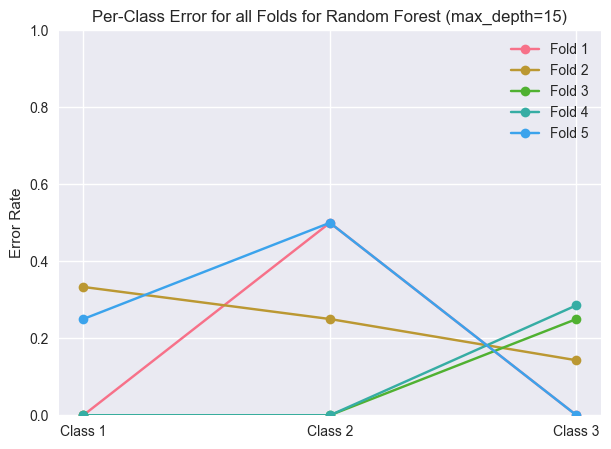

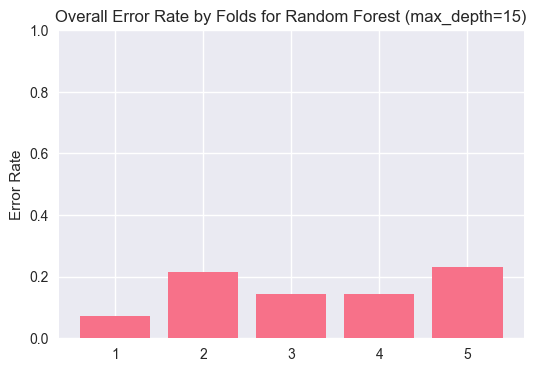

In [23]:
print("Confusion matrices for Random Forest classifiers")

for max_depth, cm in zip(max_depths, confusion_matrices_random_forest):
    error_plots(cm, f"Random Forest (max_depth={max_depth})")